# 4.9. Gráficos de esfuerzos y deformaciones

|Quién | Fecha | Qué hizo |
| ---  | ---   | ---      |
|Michael Heredia Pérez, <mherediap@unal.edu.co> | Octubre 22, 2022 | Conversión de código de MATLAB a Python|


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable     # Sólo para el tamaño de la colorbar

Se harán varias gráficas con la misma configuración o similar, así que se crea una función para automatizar el proceso. La escala de colores utilizada (*colormap* en inglés) es ```bwr```.

In [29]:
from cmath import isclose


def plot_esf_def(variable, titulo, nombre, angulo = None):
    """Función para graficar los esfuerzos y las deformaciones. Usar:
    
    Variables:
        var    : es la variable que se quiere graficar.
        titulo : título del gráfico.
        angulo : (opcional) inlcinaciones para los esf. ppls s1, s2 y tmax.
    """
    global x, y

    # Creo el lienzo.
    fig, ax = plt.subplots()
    
    # Coloreo el gráfico según la variable.
    im = ax.contourf(x, y, variable, 50, cmap = 'bwr', alpha=0.8)
    # Grafico las curvas de nivel.
    ax.contour(x, y, variable, 20, colors = "black", linewidths = 0.5, 
               linestyles = "solid")
    # Creo un axes adicional a la derecha en donde va la escala de colores.
    divider = make_axes_locatable(ax)
    # Creo la escala de colores.
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Configuro la escala para mostrar 5 intervalos/4 etiquetas.
    fig.colorbar(im, cax = cax).ax.locator_params(nbins = 5)
        
    # Para los esfuerzos principales se grafican las líneas que indiquen las
    # direcciones de los esfuerzos en cada nodo de la malla
    if angulo is not None:
       if type(angulo) is np.ndarray: 
           angulo = [ angulo ]
       for ang in angulo:
           ax.quiver(x, y, variable*np.cos(ang), variable*np.sin(ang),  
                headwidth=0, headlength=0, headaxislength=0, pivot="middle" 
                )
    
    # Se especifican los ejes y el título, y se colocan los ejes iguales.
    ax.set_xlabel("$x$ [m]")
    ax.set_ylabel("$y$ [m]")
    ax.set_title(titulo, fontsize=15)
    ax.set_aspect('equal')
    ax.autoscale(tight=True)    
    plt.tight_layout()

    plt.show()

    """
    FALTA:
    Se quier que el blanco coincida siempre con el cero (0) sin afectar la 
    visualización.
    """

El problema que tenemos es una viga simplemente apoyada como se observa en la siguiente imagen:

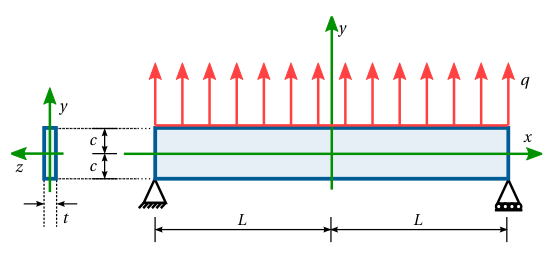

In [30]:
from IPython import display
display.Image("https://raw.githubusercontent.com/michaelherediaperez/mecanica_de_solidos_un/main/figs/viga.png")


Definimos las dimensiones, cargas y propiedades constitutivas.

In [31]:
# Propiedades geométricas de la viga
c = 0.50    # m, altura = 2c
L = 3.00    # m, luz    = 2L

# Se calcula la inercia I = bh^3/12, con b=1 y h=2c
I = (2*c**3)/3

# Carga aplicada
q = -10.0 # kN/m

# Propiedades del material
E  = 21e6         # kPa = 21 GPa, módulo de Young.
nu = 0.23         # ad          , coeficiente de Poisson.
G  = E/(2*(1+nu)) # kPa         , módulo de cortante.

La viga puede consdierarse como un caso de tensión plana ($\sigma_z = \tau_{xz} = \tau_{yz} = 0$). Los esfuerzos al interior de la viga estarán caracterizados por las siguientes ecuaciones: 

$$
\begin{align*}
\sigma_x(x,y,z)  &= -\frac{q}{2I} \left( x^2y - \frac{2}{3}y^3 + \frac{2}{5}c^2y - L^2y \right) \\
\sigma_y(x,y,z)  &= -\frac{q}{2I} \left( \frac{1}{3}y^3 - c^2y - \frac{2}{3}c^3 \right) \\
\sigma_z(x,y,z)  &= 0 \\
\tau_{xy}(x,y,z) &= -\frac{q}{2I}(c^2 - y^2)x \\
\tau_{xz}(x,y,z) &= 0 \\
\tau_{yz}(x,y,z) &= 0 
\end{align*}
$$

Como se puede ver, hay una distribución constante en la profundidad $z$ de la viga.

Para calcular las ecuaciones anteriores, es necesario discretizar la geometría del sólido, esto lo hacemos mediante una malla o grilla:

In [32]:
# Se crea la grilla de puntos donde se harán los cálculos.
nnds_x = 30
nnds_y = 15
x, y = np.meshgrid( np.linspace(-L, L, nnds_x), np.linspace(-c, c, nnds_y) )

Se calculan las distribuciones:

In [33]:
# Se definen los esfuerzos (en tensión plana sz = txz = tyz = 0), eq (4.46)
sx  = -(q/(2*I))*(x**2*y - 2*y**3/3 + 2*c**2*y/5 - L**2*y)
sy  = -(q/(2*I))*(y**3/3 - c**2*y - 2*c**3/3)
txy = -(q/(2*I))*(c**2 - y**2)*x

# Se calculan las deformaiones, eq (4.36)
ex  = (1/E)*(sx - nu*sy)
ey  = (1/E)*(sy - nu*sx)
ez  = -(nu/E)*(sx + sy)
gxy = txy/G

# Se calculan los esfuerzos principales, los esfuerzos cortantes máximos y sus 
# ángulos.
tmax = np.sqrt( ((sx - sy)/2)**2 + txy**2 )
s1 = (sx + sy)/2 + tmax
s2 = (sx + sy)/2 - tmax
t1 = np.arctan2(2*txy, sx-sy)/2     
t2 = t1 + np.pi/2                   # t1 + 90°

In [34]:
l = [sx, sy, txy, ex, ey, ez, gxy, tmax, s1, s2]
for i in l:
    print(np.min(i), np.max(i))

-271.67895362663495 271.67895362663495
-10.000000000000002 8.326672684688674e-16
-45.0 45.0
-1.282756922031595e-05 1.293709302983976e-05
-2.975531396863145e-06 2.499340920672669e-06
-2.975531396863145e-06 3.085055206386954e-06
-5.271428571428572e-06 5.271428571428572e-06
0.999999999999996 135.83947681331748
-10.0 271.67895362663495
-271.67895362663495 8.881784197001252e-16


Realizamos los gráficos empleando la función definida anteriormente:

## Esfuerzos $\sigma_x$, $\sigma_y$ y $\tau_{xy}$

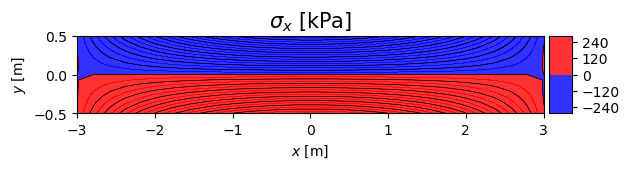

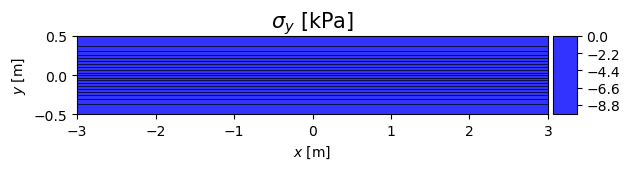

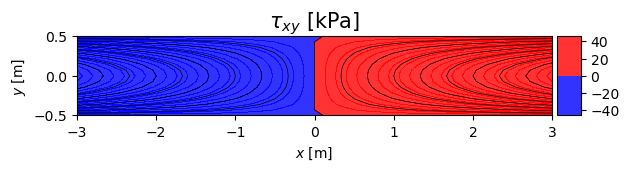

In [35]:
plot_esf_def(sx,   r'$\sigma_x$ [kPa]', "sigma_x")
plot_esf_def(sy,   r'$\sigma_y$ [kPa]', "sigma_y")
plot_esf_def(txy,  r'$\tau_{xy}$ [kPa]', "tau_xy")

## Deformaciones $\varepsilon_x$, $\varepsilon_y$, $\varepsilon_z$ y $\gamma_{xy}$

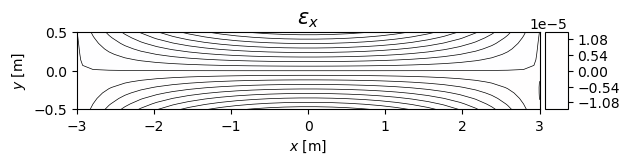

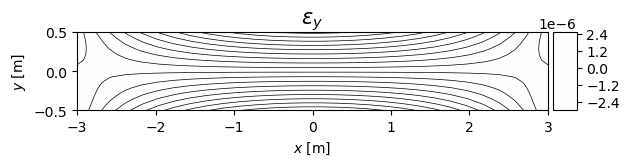

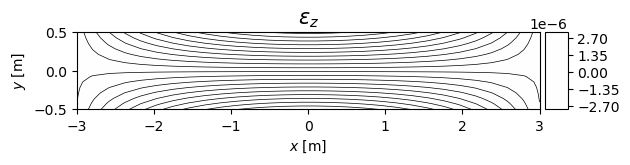

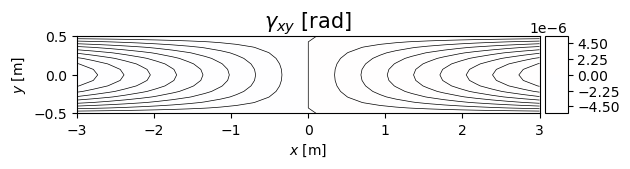

In [36]:
plot_esf_def(ex,   r'$\epsilon_x$',        "epsilon_x")
plot_esf_def(ey,   r'$\epsilon_y$',        "epsilon_y")
plot_esf_def(ez,   r'$\epsilon_z$',        "epsilon_z")
plot_esf_def(gxy,  r'$\gamma_{xy}$ [rad]', "gamma_xy")

## Esfuerzos principales $(\sigma_1)_{xy}$ y $(\sigma_1)_{xy}$

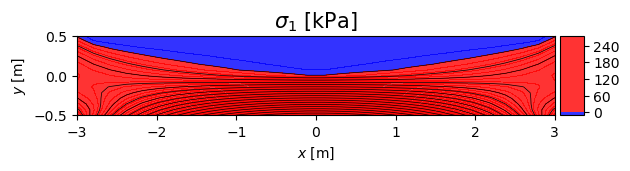

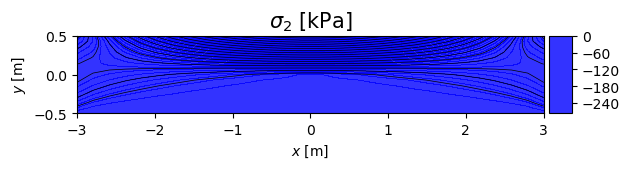

In [37]:
# SIN las inclinaciones
plot_esf_def(s1, r"$\sigma_1$ [kPa]", "s1")
plot_esf_def(s2, r"$\sigma_2$ [kPa]", "s2") 

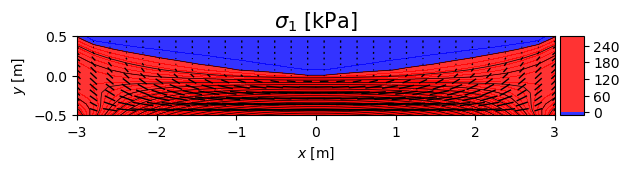

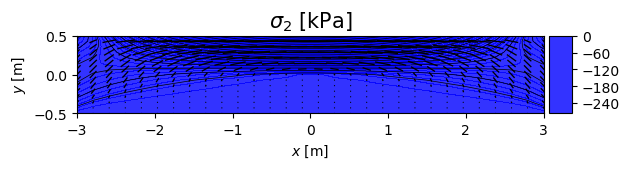

In [38]:
# CON las inclinaciones
plot_esf_def(s1, r"$\sigma_1$ [kPa]", "s1", t1)
plot_esf_def(s2, r"$\sigma_2$ [kPa]", "s2", t2) 

## Esfuerzo cortante máximo $(\tau_{max})_{xy}$

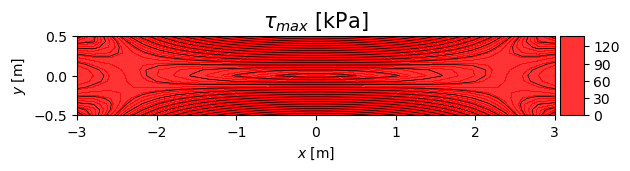

In [39]:
# SIN las inclinaciones
plot_esf_def(tmax, r'$\tau_{max}$ [kPa]', "tmax")

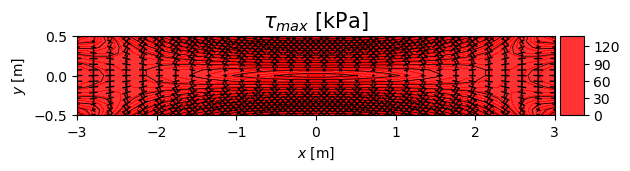

In [40]:
# CON las inclinaciones
plot_esf_def(tmax, r'$\tau_{max}$ [kPa]', "tmax",[ t1-np.pi/4, t1+np.pi/4 ])

## Diagramas de fuerza cortante y momento flector

Las ecuaciones para la fuerza cortante $V(x)$ y el momento flector $M(x)$ son:

$$
\begin{align*}
V(x) &= qx \\
M(x) &= -\frac{q}{2}(L^2 - x^2)
\end{align*}
$$

In [41]:
# Defino el dominio de evaluación.
xx = np.linspace(-L, L, nnds_x)

# Calculo la fuerza cortante y le momento flector.
vx = q*xx
mx = -q/2*(L**2 - xx**2)

Se construyen los diagramas

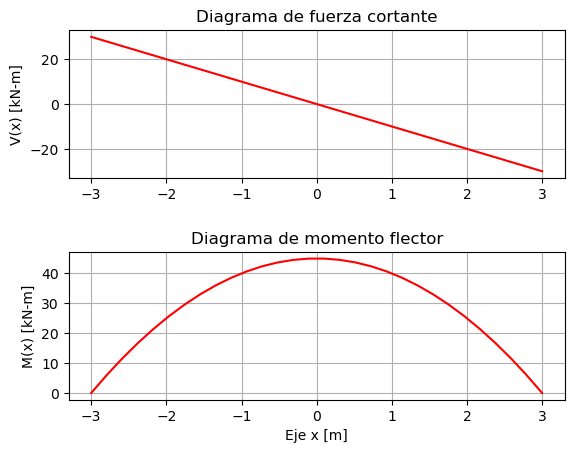

In [42]:
fig = plt.figure()
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(2):
    ax = fig.add_subplot(2, 1, i+1)
    ax.grid()
    if i == 0:
        ax.plot(xx, vx, '-r')
        ax.set_ylabel("V(x) [kN-m]")
        ax.set_title("Diagrama de fuerza cortante")
    if i == 1:
        ax.plot(xx, mx, '-r')
        ax.set_xlabel("Eje x [m]")
        ax.set_ylabel("M(x) [kN-m]")
        ax.set_title("Diagrama de momento flector")
plt.show()